# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.


## Fire up Scikit-learn, Pandas and Numpy

In [22]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

## Load review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [23]:
products = pd.read_csv('amazon_baby_subset.csv')

2.. Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

~Remove punctuation

~Compute word counts (only for the important_words)

We start with the first item as follows:

If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [24]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

Write a function remove_punctuation that takes a line of text and removes all punctuation from that text. The function should be analogous to the following Python code:

In [25]:
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator) 

Apply the remove_punctuation function on every element of the review column and assign the result to the new column review_clean. Note. Many data frame packages support apply operation for this type of task. Consult appropriate manuals.

In [26]:
products['review_clean'] = products['review'].astype(str).apply(remove_punctuation) #astype(str) makes sure all reviews are strings

3.. Now we proceed with the second item. For each word in important_words, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in important_words which keeps a count of the number of times the respective word occurs in the review text.

Note: There are several ways of doing this. One way is to create an anonymous function that counts the occurrence of a particular word and apply it to every element in the review_clean column. Repeat this step for every word in important_words. Your code should be analogous to the following:

In [27]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [28]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

4.. After #2 and #3, the data frame products should contain one column for each of the 193 important_words. As an example, the column perfect contains a count of the number of times the word prefect occurs in each of the reviews.

In [29]:
products['perfect'].head()

0    0
1    0
2    0
3    1
4    0
Name: perfect, dtype: int64

## Train-Validation split


In [30]:
#read the index documents
traindata = pd.read_json('module-4-assignment-train-idx.json')
validdata = pd.read_json('module-4-assignment-validation-idx.json')

In [32]:
#pull train and test data from products data using the index docs
train_data = products.loc[traindata.values.reshape((-1,))]
validation_data = products.loc[validdata.values.reshape((-1,))]

## Convert DataFrame to NumPy array

6.. Convert train_data and validation_data into multi-dimensional arrays.

Using the function given in #8 of Module 3 assignment, extract two arrays feature_matrix_train and sentiment_train from train_data. The 2D array feature_matrix_train would contain the content of the columns given by the list important_words. The 1D array sentiment_train would contain the content of the column sentiment. Do the same for validation_data, producing the arrays feature_matrix_valid and sentiment_valid. The code should be analogous to this cell:

In [33]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    #print(features)
    features_frame = dataframe[features]
    #print(dataframe[features])
    #print(features_frame)
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)

In [34]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [35]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+(np.exp(-score)))
    
    # return predictions
    return predictions

# Adding  L2 penalty

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [45]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = derivative-2*l2_penalty*coefficient
        
    return derivative

Quiz question: In the code above, was the intercept term regularized?

In [38]:
print('The answer is: no')

The answer is: no


10.. To verify the correctness of the gradient descent algorithm, we write a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability), which is given by the formula

In [46]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

Quiz question: Does the term with L2 regularization increase or decrease ℓℓ(w)?

In [114]:
print('The answer is: decrease')

The answer is: decrease


11.. The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.

Write a function logistic_regression_with_L2 to fit a logistic regression model under L2 regularization.

In [58]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            #print('derivative', derivative)
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

12.. Now that we have written up all the pieces needed for an L2 solver with logistic regression, let's explore the benefits of using L2 regularization while analyzing sentiment for product reviews. As iterations pass, the log likelihood should increase.

Let us train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation. Train 6 models with L2 penalty values 0, 4, 10, 1e2, 1e3, and 1e5. Use the following values for the other parameters:

feature_matrix = feature_matrix_train extracted in #7

sentiment = sentiment_train extracted in #7

initial_coefficients = a 194-dimensional vector filled with zeros

step_size = 5e-6

max_iter = 501

In [59]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [60]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [61]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [62]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [63]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [64]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [65]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [66]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941


In [67]:
table

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
5,use,-0.000104,0.000163,0.000556,0.005481,0.017326,0.000418
6,would,-0.287021,-0.286027,-0.284564,-0.265993,-0.188662,-0.008127
7,like,-0.003384,-0.003442,-0.003527,-0.004635,-0.007043,-0.000827
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
9,little,0.524419,0.521385,0.516917,0.460235,0.251221,0.005941


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [76]:
new_table = table.sort_values('coefficients [L2=0]', ascending=False)[0:5]
new_table

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
23,loves,1.052484,1.043903,1.031265,0.870794,0.345870,0.006150
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
34,perfect,0.835693,0.828555,0.818038,0.684143,0.250614,0.003989
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950


In [106]:
positive_words = new_table['word']
positive_words.index = range(5)
positive_words

0       love
1      loves
2       easy
3    perfect
4      great
Name: word, dtype: object

In [75]:
new_table_2 = table.sort_values('coefficients [L2=0]', ascending=True)[0:5]
new_table_2

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
106,disappointed,-0.955437,-0.946980,-0.934518,-0.775625,-0.266095,-0.004013
97,money,-0.768793,-0.762734,-0.753818,-0.641406,-0.275883,-0.005487
114,return,-0.742085,-0.735502,-0.725807,-0.602646,-0.215199,-0.003730
113,waste,-0.617809,-0.612475,-0.604620,-0.505189,-0.190631,-0.003345
169,returned,-0.572707,-0.567518,-0.559870,-0.462056,-0.150021,-0.002225


In [105]:
negative_words = new_table_2['word']
negative_words.index = range(5)
negative_words

0    disappointed
1           money
2          return
3           waste
4        returned
Name: word, dtype: object

14.. Let us observe the effect of increasing L2 penalty on the 10 words just selected. Make a plot of the coefficients for the 10 words over the different values of L2 penalty.

Hints:

First, extract rows corresponding to positive_words. Do the same for negative_words.
Then plot each of the extracted rows. The x axis should be L2 penalty and the y axis should be the coefficient value.
Use log scale for the x axis, as the L2 penalty values are exponentially spaced.

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].values.flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].values.flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


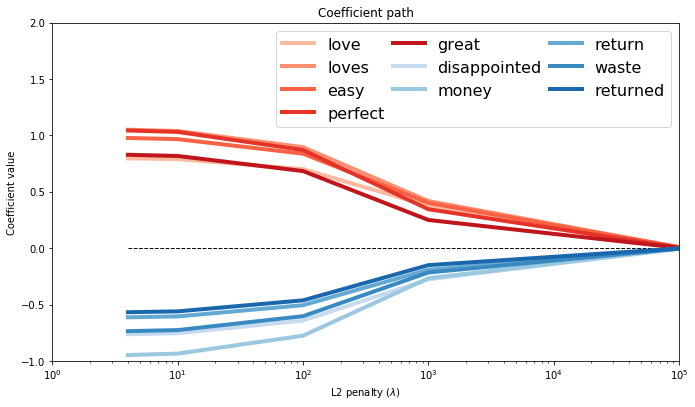

In [107]:
#make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])
l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5]
cmap_positive = plt.get_cmap('Reds')
cmap_negative = plt.get_cmap('Blues')

xx = l2_penalty_list
plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')

table_positive_words = table[table['word'].isin(positive_words)]
table_negative_words = table[table['word'].isin(negative_words)]
del table_positive_words['word']
del table_negative_words['word']

for i in range(len(positive_words)):
    color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
    plt.plot(xx, table_positive_words[i:i+1].values.flatten(),
             '-', label=positive_words[i], linewidth=4.0, color=color)

for i in range(len(negative_words)):
    color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
    plt.plot(xx, table_negative_words[i:i+1].values.flatten(),
             '-', label=negative_words[i], linewidth=4.0, color=color)

plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
plt.axis([1, 1e5, -1, 2])
plt.title('Coefficient path')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('Coefficient value')
plt.xscale('log')
plt.rcParams.update({'font.size': 18})
plt.tight_layout()

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.


**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

In [108]:
print('The answer is True')
print('The answer is False')

The answer is True
The answer is False


## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [109]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [110]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [111]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key)
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print ("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.785156157787, validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785108944548, validation_accuracy = 0.781533003454
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.784990911452, validation_accuracy = 0.781719727383
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.783975826822, validation_accuracy = 0.781066193633
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.775855149784, validation_accuracy = 0.771356549342
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.680366374731, validation_accuracy = 0.667818130893
---------------------------------------------------------------------------

<function matplotlib.pyplot.tight_layout>

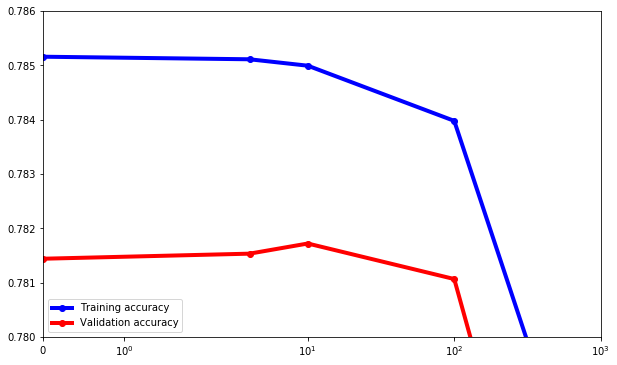

In [112]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?

In [113]:
print('The answer: the highest accuracy on the training data: L2 penalty = 0')
print('The answer: the highest accuracy on the validation data: L2 penalty = 10')
print('The answer: no')

The answer: the highest accuracy on the training data: L2 penalty = 0
The answer: the highest accuracy on the validation data: L2 penalty = 10
The answer: no
